<a href="https://colab.research.google.com/github/sainiakhil/Segment-Anything-ControlNet-based-project/blob/main/Segment_Anything_%2B_ControlNet_based_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

!pip install git+https://github.com/IDEA-Research/GroundingDINO.git
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!git clone https://github.com/IDEA-Research/GroundingDINO.git


In [ ]:
!pip install diffusers
!pip install torch torchaudio
!pip install transformers
!pip install accelerate


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import math
import os
from PIL import Image
import transformers
from accelerate import Accelerator
from google.colab.patches import cv2_imshow

## **Segment Anything Model**

In [ ]:
from segment_anything import sam_model_registry
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint="/content/sam_vit_h_4b8939.pth")
sam.to(device=DEVICE)

In [ ]:
# intializing sam object

from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
image_bgr = cv2.imread("/content/john-torcasio--wP-QJgM4Mc-unsplash.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)


In [ ]:
print(result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


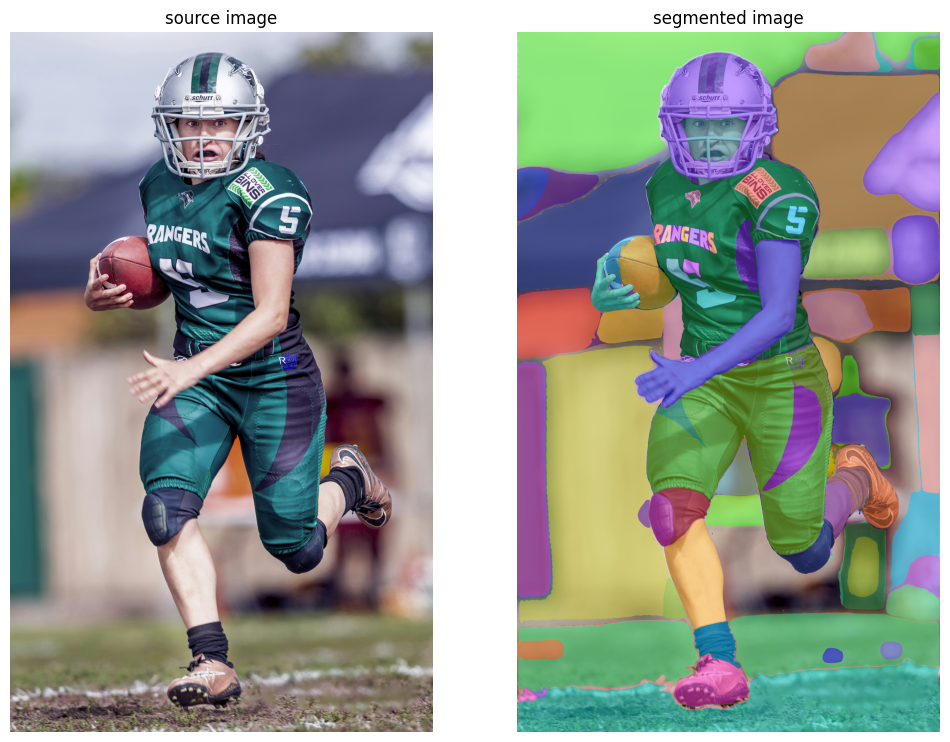

In [ ]:

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result = result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


## **GroundingDINO Model + Segment Anything Model**

In [ ]:
# Initialize the accelerator
accelerator = Accelerator()
device = accelerator.device

In [ ]:
from GroundingDINO.groundingdino.util.inference import load_model, load_image, predict, annotate, Model
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry,  SamPredictor

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device is: CUDA") if torch.cuda.is_available else print("Device is: CPU")

Device is: CUDA


In [ ]:
grounding_dino_model = Model(
    model_config_path= "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
    model_checkpoint_path='/content/groundingdino_swint_ogc.pth',
)

final text_encoder_type: bert-base-uncased


In [ ]:
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25


# input images
IMAGE_PATH = "/content/WhatsApp Image 2024-06-22 at 9.31.29 AM.jpeg"
# objects we want to create masks for
TEXT_PROMPT = "men. face. head. tshirt."

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [ ]:
# detect objects
detections, phrases = grounding_dino_model.predict_with_caption(
    image=image_bgr,
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
)

detections.class_id = phrases

In [ ]:
# helper functions

def segment(
    sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray
) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(box=box, multimask_output=True)
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)


def make_annots_from_prompt(detections_object):

    if len(detections.xyxy) == 0:
        return None

    annotations = [{"name": "image id: {}".format(detections.tracker_id), "data": []}]

    for i in range(len(detections.xyxy)):
        annotations[0]["data"].append(
            {
                "label": detections.class_id[i],
                "score": round((detections.confidence[i] * 100), 2),
                "points": make_sam_mask(detections.mask[i]),
            }
        )

    return annotations


def plot_images_grid(images, grid_size, title, size, cmap="gray"):
    nrows, ncols = grid_size

    if len(images) > nrows * ncols:
        raise ValueError(
            "The number of images exceeds the grid size. Please increase the grid size or reduce the number of images."
        )

    if nrows == 1 and ncols == 1:
        fig, ax = plt.subplots(figsize=size)
        if images[0].ndim == 2:
            ax.imshow(images[0], cmap)
        else:
            ax.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

        if titles is not None:
            ax.set_title(titles[0])

        ax.axis("off")
    else:
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=size)

        for idx, ax in enumerate(axes.flat):
            if idx < len(images):
                if images[idx].ndim == 2:
                    ax.imshow(images[idx], cmap=cmap)
                else:
                    ax.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))

                if titles is not None and idx < len(titles):
                    ax.set_title("{}, mask {}".format(titles[idx], idx))

            ax.axis("off")
    plt.show()

In [ ]:
# Instantiate SAM model

with strategy.scope():

  MODEL_TYPE = "vit_h"

  sam = sam_model_registry[MODEL_TYPE](checkpoint="/content/sam_vit_h_4b8939.pth")

  mask_generator = SamAutomaticMaskGenerator(sam)

  sam_predictor = SamPredictor(sam)

In [ ]:
# convert bbox detections to masks and add to detections object
detections.mask = segment(
    sam_predictor=sam_predictor, image=image_bgr, xyxy=detections.xyxy
)

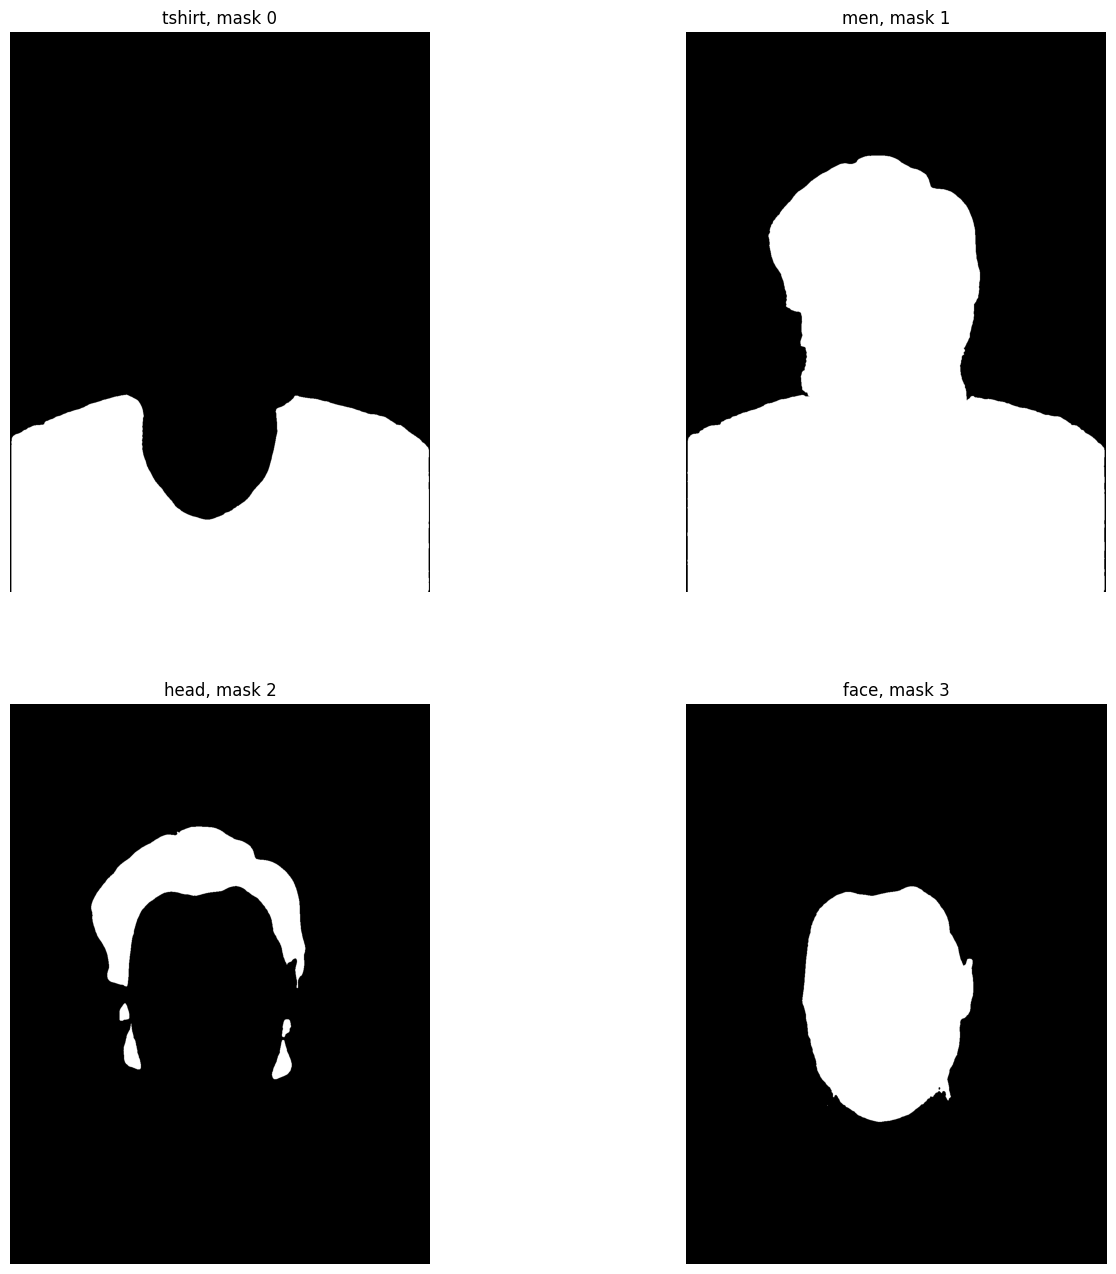

In [ ]:
grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

titles = [class_id for class_id in detections.class_id]

plot_images_grid(
    images=detections.mask,
    title=["x" for i in range(len(detections.mask))],
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16),
)

In [ ]:
men_face_mask = Image.fromarray(((detections.mask[1]) * 255).astype(np.uint8))
tshirt_mask = Image.fromarray(((detections.mask[0]) * 255).astype(np.uint8))

In [ ]:
men_face_mask.save("men_face_mask.png")
tshirt_mask.save("tshirt_mask.png")

## **StableDiffusionXLControlNetInpaintPipeline**

In [ ]:
from diffusers import StableDiffusionXLControlNetInpaintPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image

In [ ]:
# initialize the models and pipeline
#controlnet_conditioning_scale = 0.5  # recommended for good generalization
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16
)

pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.to(device)

In [ ]:
# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

# Define the transformation pipeline

# download an image
image = load_image(
    "/content/WhatsApp Image 2024-06-21 at 4.59.32 AM.jpeg"
).resize((768,768))




mask_image = load_image(
    "/content/men_mask.png")

mask_image = mask_image.resize((768, 768))



# get canny image
def make_canny_condition(image):
    image = np.array(image)
    image = cv2.Canny(image, 100, 200)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    image = Image.fromarray(image)
    return image

control_image = make_canny_condition(image)



# Generate new image using Stable Diffusion with ControlNet
generator = torch.Generator(device=device).manual_seed(52)  # Set seed for reproducibility
# Set up the scheduler
scheduler = DDIMScheduler.from_config(pipe.scheduler.config)



# Generate image
output = pipe(
    prompt="A professional headshot of a indian confident man wearing business attire, looking straight into the camera, clean background, studio lighting, well-groomed hair, neutral expression.",
    neagtive_prompt = "low quality. ugly. blur. (worst quality:1.4, low quality:1.4)",
    num_inference_steps=70,
    strength = 0.3,
    generator=generator,
    guidance_scale = 9,
    image=image,
    mask_image = mask_image,
    control_image=control_image,
    scheduler = scheduler
    # add schedular

).images[0]

In [ ]:
output.save('men_image.png')